In [1]:
from sklearn.ensemble import RandomForestClassifier

import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from sklearn.preprocessing import StandardScaler

from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier
import xgboost as xgb
import shap

In [2]:
df=pd.read_csv('trabajo_dummies.csv')

In [3]:
df

,festivo,prev_festivo,post_festivo,mult_diag,urbano,Rural,comuna_mixta,grave,tiempo_espera,rslc_porcentaje_incapacidad,...,forma_oit_6,forma_oit_7,forma_oit_8,forma_oit_9,agente_oit_1,agente_oit_2,agente_oit_3,agente_oit_4,agente_oit_5,agente_oit_6
0,0,0,0,1,0,0,1,1,4.000000,0.0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0.766667,0.0,...,0,0,0,1,1,0,0,0,0,0
2,0,0,0,1,0,0,1,1,1.700000,0.0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,1,0,2.216667,0.0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,1,0,0,0,4.883333,0.0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130747,0,0,0,0,0,0,1,0,1.850000,0.0,...,0,0,0,1,0,0,1,0,0,0
130748,0,0,0,0,0,0,1,0,1.000000,0.0,...,0,0,0,1,0,0,1,0,0,0
130749,0,1,0,1,1,0,0,0,1.183333,0.0,...,0,0,0,0,1,0,0,0,0,0
130750,0,0,0,0,0,0,1,0,4.983333,0.0,...,0,0,0,1,0,1,0,0,0,0


In [4]:

scaler = StandardScaler()

df['tiempo_espera'] = scaler.fit_transform(df[['tiempo_espera']])





In [5]:
X = df.drop('reposo', axis=1)
y= df['reposo']

In [6]:
y.value_counts()

reposo
0    124524
1      6228
Name: count, dtype: int64

In [7]:
# define pipeline
over = SMOTE(sampling_strategy=0.4) #aumenta la clase minoritaría al 40% de la mayoritaria
under = RandomUnderSampler(sampling_strategy=0.5) #reduce la clase mayoritaria para que represente un 50% más que la minoritaria
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
# transform the dataset
X_sm, y_sm = pipeline.fit_resample(X, y)

y_sm.value_counts()

reposo
0    99618
1    49809
Name: count, dtype: int64

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.3, random_state=42, stratify=y_sm)

In [9]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [10]:
y_pred = rf.predict(X_train)

print(classification_report(y_train, y_pred))
print(confusion_matrix(y_train, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     69732
           1       1.00      1.00      1.00     34866

    accuracy                           1.00    104598
   macro avg       1.00      1.00      1.00    104598
weighted avg       1.00      1.00      1.00    104598

[[69732     0]
 [    0 34866]]


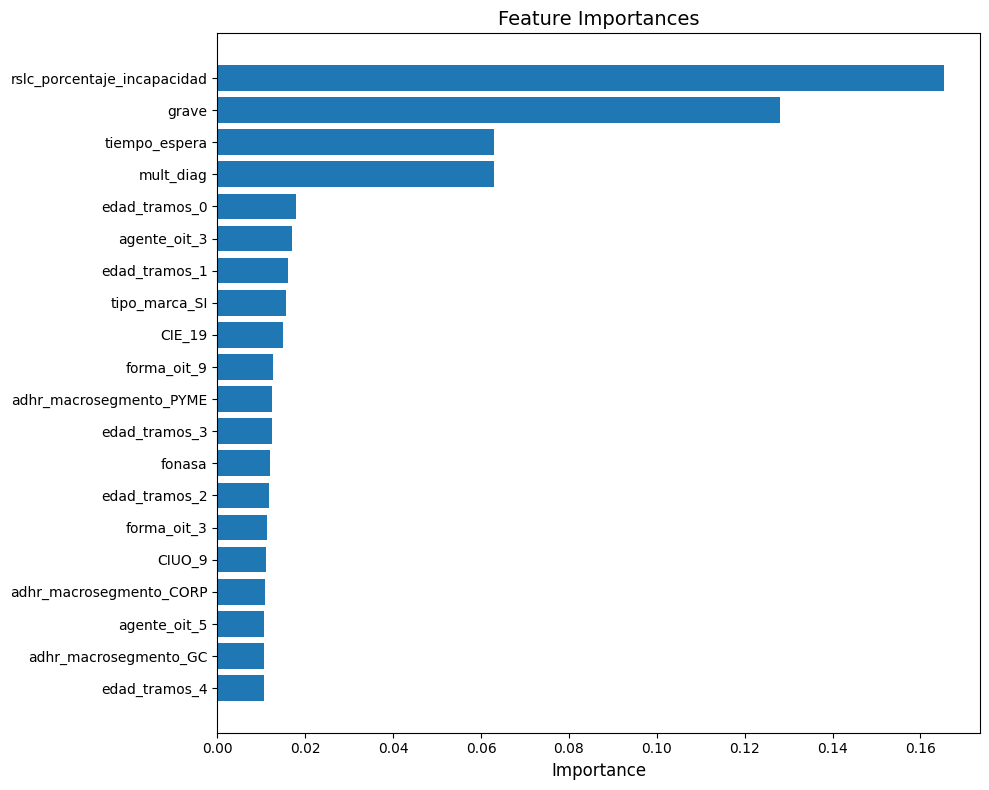

In [11]:
#muestra la importancia de cada variable

importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

#grafica de las 20 variables más importantes

plt.figure(figsize=(10, 8))
plt.title("Feature Importances", fontsize=14)
plt.barh(range(20), importances[indices[:20]], align="center")
plt.yticks(range(20), X.columns[indices[:20]])
plt.gca().invert_yaxis()  # Invertir el orden de las características
plt.xlabel("Importance", fontsize=12)
plt.tight_layout()
plt.show()



In [12]:
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98     29886
           1       0.96      0.94      0.95     14943

    accuracy                           0.97     44829
   macro avg       0.97      0.96      0.96     44829
weighted avg       0.97      0.97      0.97     44829

[[29312   574]
 [  857 14086]]


In [13]:
#kfold cross validation

kfold = KFold(n_splits=10,shuffle=True, random_state=7)
results = cross_val_score(rf, X_test, y_test, cv=kfold, scoring='accuracy')

print(results)

print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

    

[0.95337943 0.9491412  0.95070265 0.95070265 0.95204104 0.94579523
 0.94378764 0.95092572 0.95181798 0.94422133]
Accuracy: 94.93% (0.32%)
